*The data, concept, and initial implementation of this notebook was done in Colab by Ross Wightman, the creator of timm. I (Jeremy Howard) did some refactoring, curating, and expanding of the analysis, and added prose.*

## timm

[PyTorch Image Models](https://timm.fast.ai/) (timm) is a wonderful library by Ross Wightman which provides state-of-the-art pre-trained computer vision models. It's like Huggingface Transformers, but for computer vision instead of NLP (and it's not restricted to transformers-based models)!

Ross has been kind enough to help me understand how to best take advantage of this library by identifying the top models. I'm going to share here so of what I've learned from him, plus some additional ideas.

## The data

In [ ]:
from pathlib import Path
path = Path.cwd()/'timm_results'

In [ ]:
import pandas as pd
df_results = pd.read_csv(path/'results-imagenet.csv')
df_results['model_org'] = df_results['model'] 
df_results['model'] = df_results['model'].str.split('.').str[0]

We'll also add a "family" column that will allow us to group architectures into categories with similar characteristics:

Ross has told me which models he's found the most usable in practice, so I'll limit the charts to just look at these. (I also include VGG, not because it's good, but as a comparison to show how far things have come in the last few years.)

In [ ]:
def get_data(part, col):
    df = pd.read_csv(path/f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg')]

In [ ]:
df = get_data('infer', 'infer_samples_per_sec')
df.head()

,model,infer_samples_per_sec,infer_step_time,infer_batch_size,infer_img_size,param_count_x,top1,top1_err,top5,top5_err,param_count_y,img_size,crop_pct,interpolation,model_org,secs,family
12,levit_128s,21485.80,47.648,1024,224,7.78,76.526,23.474,92.872,7.128,7.78,224,0.900,bicubic,levit_128s.fb_dist_in1k,0.000047,levit
13,regnetx_002,17821.98,57.446,1024,224,2.68,68.746,31.254,88.536,11.464,2.68,224,0.875,bicubic,regnetx_002.pycls_in1k,0.000056,regnetx
15,regnety_002,16673.08,61.405,1024,224,3.16,70.278,29.722,89.528,10.472,3.16,224,0.875,bicubic,regnety_002.pycls_in1k,0.000060,regnety
17,levit_128,14657.83,69.849,1024,224,9.21,78.490,21.510,94.012,5.988,9.21,224,0.900,bicubic,levit_128.fb_dist_in1k,0.000068,levit
18,regnetx_004,14440.03,70.903,1024,224,5.16,72.398,27.602,90.828,9.172,5.16,224,0.875,bicubic,regnetx_004.pycls_in1k,0.000069,regnetx


## Inference results

Here's the results for inference performance (see the last section for training performance). In this chart:

- the x axis shows how many seconds it takes to process one image (**note**: it's a log scale)
- the y axis is the accuracy on Imagenet
- the size of each bubble is proportional to the size of images used in testing
- the color shows what "family" the architecture is from.

Hover your mouse over a marker to see details about the model. Double-click in the legend to display just one family. Single-click in the legend to show or hide a family.

In [ ]:
import plotly.express as px
w,h = 1000,800

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])

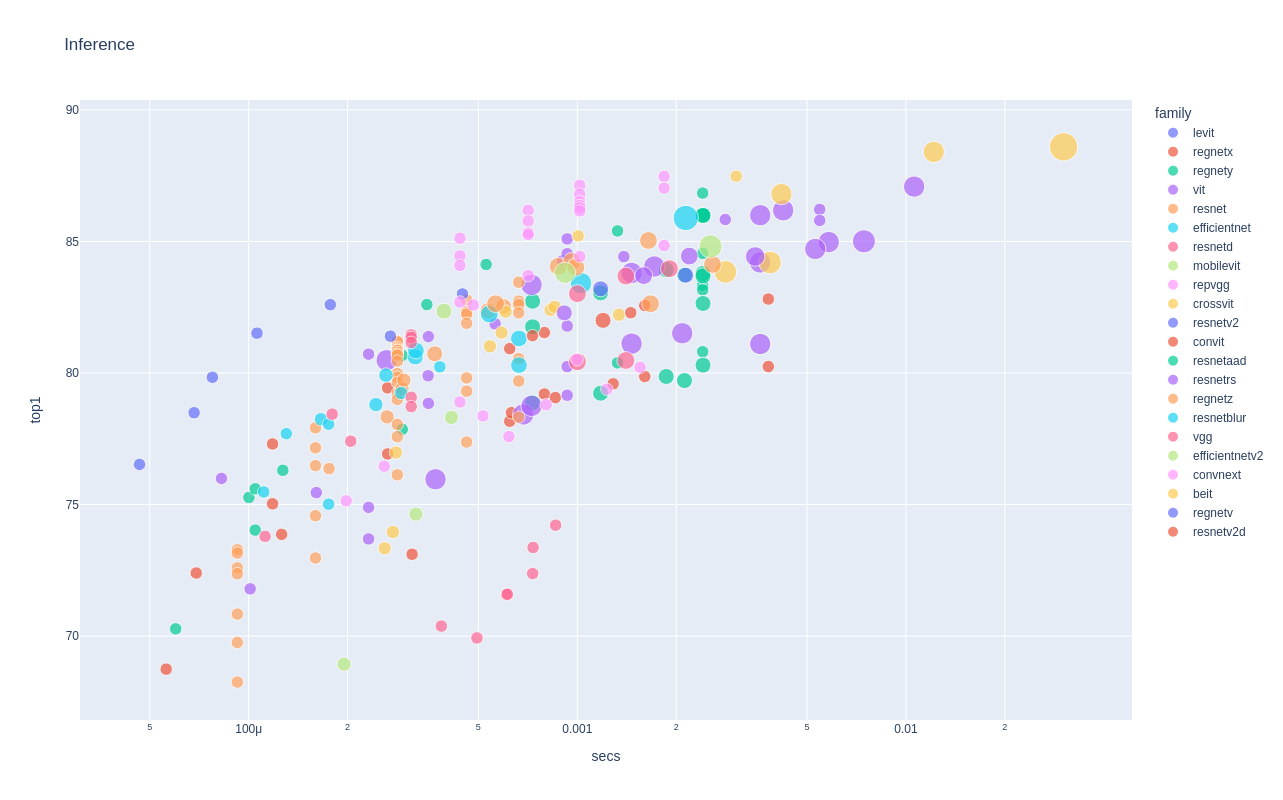

In [ ]:
show_all(df, 'Inference', 'infer_img_size')

That number of families can be a bit overwhelming, so I'll just pick a subset which represents a single key model from each of the families that are looking best in our plot. I've also separated convnext models into those which have been pretrained on the larger 22,000 category imagenet sample (`convnext_in22`) vs those that haven't (`convnext`). (Note that many of the best performing models were trained on the larger sample -- see the papers for details before coming to conclusions about the effectiveness of these architectures more generally.)

In [ ]:
subs = 'levit|resnetd?|regnetx|vgg|convnext.*|efficientnetv2|beit'

In this chart, I'll add lines through the points of each family, to help see how they compare -- but note that we can see that a linear fit isn't actually ideal here! It's just there to help visually see the groups.

In [ ]:
def show_subs(df, title, size):
    df_subs = df[df.family.str.fullmatch(subs)]
    return px.scatter(df_subs, width=w, height=h, size=df_subs[size]**2, title=title,
        trendline="ols", trendline_options={'log_x':True},
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])

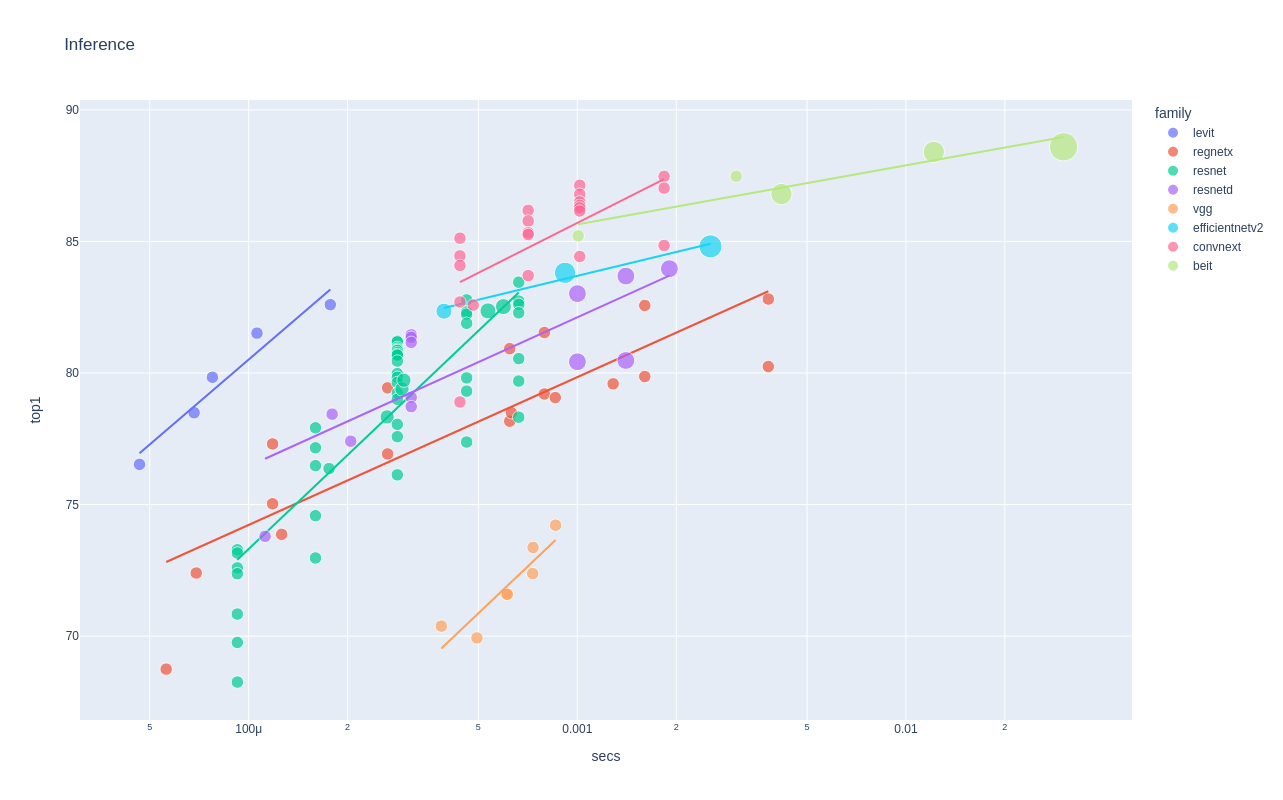

In [ ]:
show_subs(df, 'Inference', 'infer_img_size')

From this, we can see that the *levit* family models are extremely fast for image recognition, and clearly the most accurate amongst the faster models. That's not surprising, since these models are a hybrid of the best ideas from CNNs and transformers, so get the benefit of each. In fact, we see a similar thing even in the middle category of speeds -- the best is the ConvNeXt, which is a pure CNN, but which takes advantage of ideas from the transformers literature.

For the slowest models, *beit* is the most accurate -- although we need to be a bit careful of interpreting this, since it's trained on a larger dataset (ImageNet-21k, which is also used for *vit* models).

I'll add one other plot here, which is of speed vs parameter count. Often, parameter count is used in papers as a proxy for speed. However, as we see, there is a wide variation in speeds at each level of parameter count, so it's really not a useful proxy.

(Parameter count may be be useful for identifying how much memory a model needs, but even for that it's not always a great proxy.)

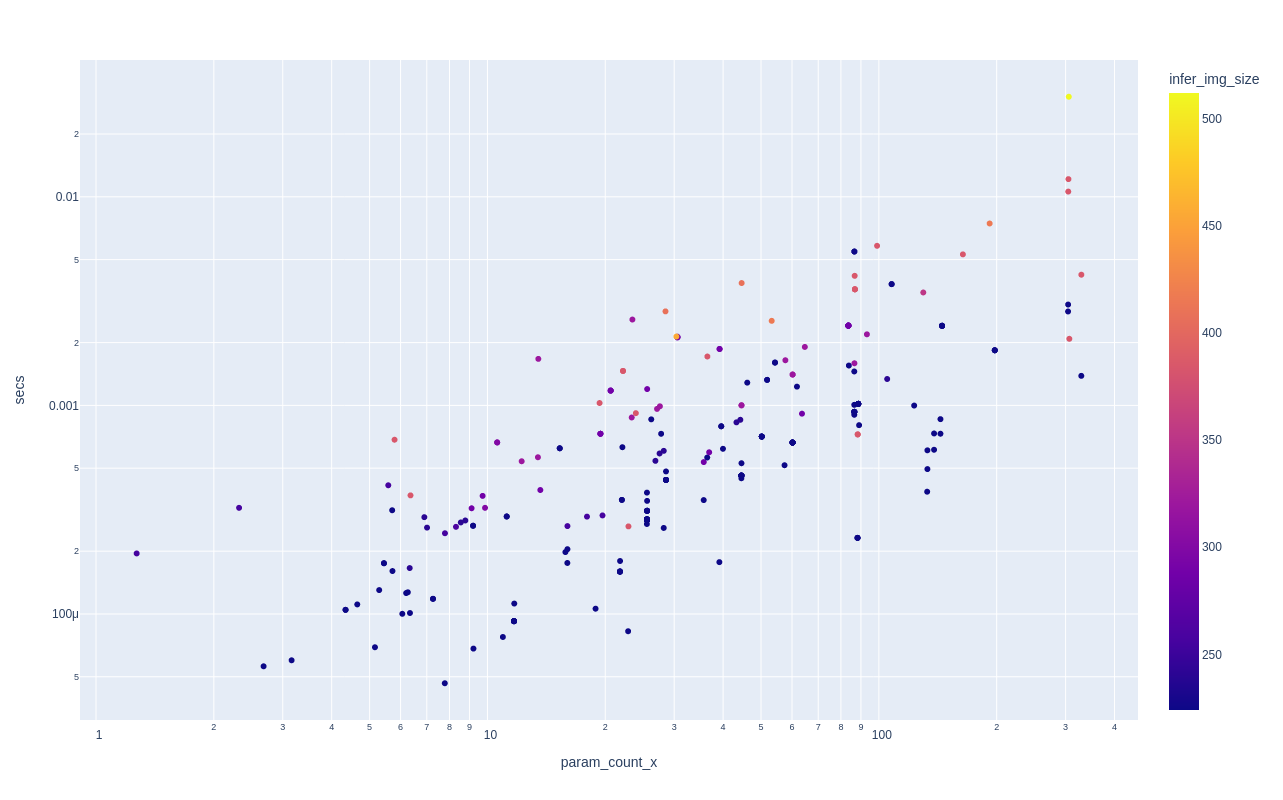

In [ ]:
px.scatter(df, width=w, height=h,
    x='param_count_x',  y='secs', log_x=True, log_y=True, color='infer_img_size',
    hover_name='model', hover_data=['infer_samples_per_sec', 'family']
)

## Training results

We'll now replicate the above analysis for training performance. First we grab the data:

In [ ]:
tdf = get_data('train', 'train_samples_per_sec')

Now we can repeat the same *family* plot we did above:

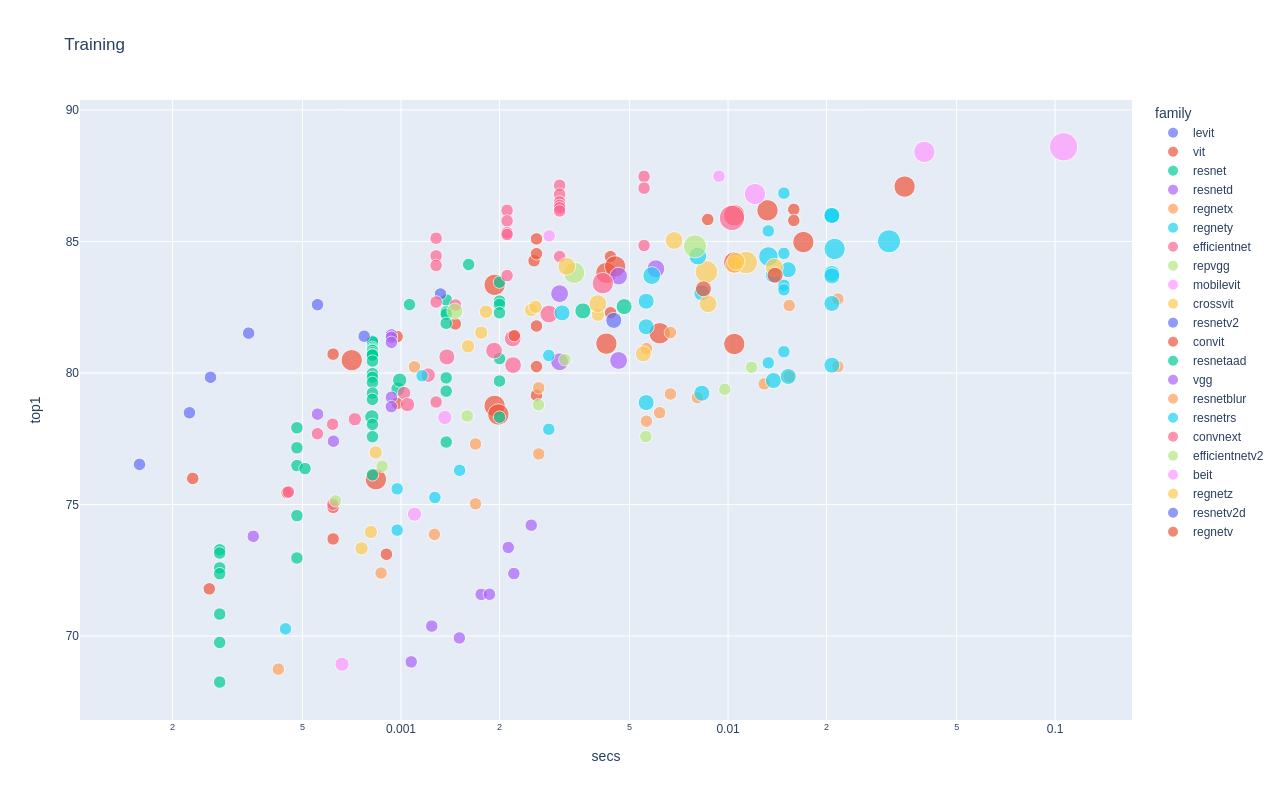

In [ ]:
show_all(tdf, 'Training', 'train_img_size')

...and we'll also look at our chosen subset of models:

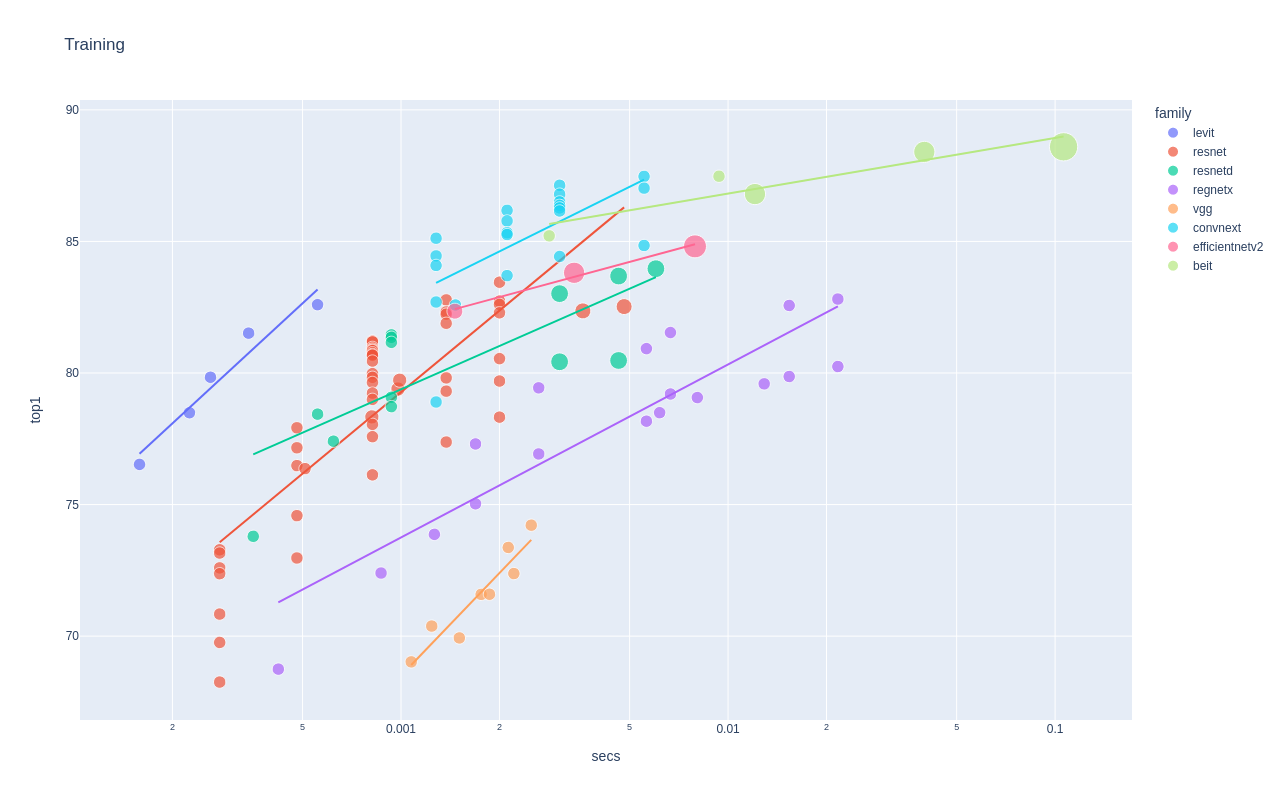

In [ ]:
show_subs(tdf, 'Training', 'train_img_size')

Finally, we should remember that speed depends on hardware. If you're using something other than a modern NVIDIA GPU, your results may be different. In particular, I suspect that transformers-based models might have worse performance in general on CPUs (although I need to study this more to be sure).